# Predicting Mouse Decision Outcomes from Neural Activity

### Abstract:

This project analyzes neural data from Steinmetz et al. (2019) to predict trial outcomes (success or failure) for four mice across 18 experimental sessions. Using visual stimuli contrasts and neural spike trains from the visual cortex, exploratory data analysis is conducted to uncover patterns, data is integrated across sessions by summarizing neural activity, and predictive models are built for a test set. The models achieve accuracies of approximately 70-80% on training data, with performance evaluated on test sets from Sessions 1 and 18.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

pandas2ri.activate()

### Section I - Introduction

The study by Steinmetz et al. (2019) investigated decision-making in mice by presenting visual stimuli on left and right screens, with contrast levels of 0, 0.25, 0.5, or 1. Mice turned a wheel to indicate their choice, receiving feedback based on these rules:

Left contrast > right contrast: Success (1) if turned right, failure (-1) otherwise.

Right contrast > left contrast: Success (1) if turned left, failure (-1) otherwise.

Both contrasts zero: Success (1) if held still, failure (-1) otherwise.

Equal non-zero contrasts: Random correct direction (50% chance).

The mice were rewarded for making the right choice, whilst getting penalized for making the wrong choice. Neural activity was recorded during these trials, providing insights into the relationship between sensory input, brain activity, and decision outcomes. This project focuses on 18 sessions from four mice (Cori, Frossman, Hence, Lederberg), using variables like feedback_type (1 or -1), contrast_left, contrast_right, and spks (spike counts). Our objective is to predict feedback_type using stimuli and neural data, structured in three parts: exploratory analysis, data integration, and predictive modeling, with performance assessed on test sets from Sessions 1 and 18.

In [2]:
def read_rds(file_path):
    return ro.r['readRDS'](file_path)

# Load all 18 sessions (adjust paths as needed)
sessions = [read_rds(f'./Data/session{i}.rds') for i in range(1, 19)]

In [3]:
summary = []
for i, sess in enumerate(sessions):
    mouse = sess.rx2('mouse_name')[0]
    num_trials = len(sess.rx2('feedback_type'))
    num_neurons = len(sess.rx2('brain_area'))
    feedback_type = np.array(sess.rx2('feedback_type'))
    success_rate = np.mean(feedback_type == 1)
    summary.append({
        'session': i+1,
        'mouse': mouse,
        'num_trials': num_trials,
        'num_neurons': num_neurons,
        'success_rate': success_rate
    })
summary_df = pd.DataFrame(summary)
print(summary_df)

    session      mouse  num_trials  num_neurons  success_rate
0         1       Cori         114          734      0.605263
1         2       Cori         251         1070      0.633466
2         3       Cori         228          619      0.662281
3         4  Forssmann         249         1769      0.666667
4         5  Forssmann         254         1077      0.661417
5         6  Forssmann         290         1169      0.741379
6         7  Forssmann         252          584      0.670635
7         8      Hench         250         1157      0.644000
8         9      Hench         372          788      0.685484
9        10      Hench         447         1172      0.619687
10       11      Hench         342          857      0.795322
11       12  Lederberg         340          698      0.738235
12       13  Lederberg         300          983      0.796667
13       14  Lederberg         268          756      0.694030
14       15  Lederberg         404          743      0.764851
15      

### Section II - Exploratory Data Analysis

The dataset is explored to understand its structure and patterns across 18 sessions. Each session, labelled with the mouse name and experiment date, includes 5 variables: feedback type (1 and -1), the contrast of the left stimulus, the contrast of the right stimulus, time bins of the spikes, the number of spikes in the time bins, and the brain area where each neuron resides. In particular, these variables are analyzed to effectively build a predictive model of the feedback type based on other factors.

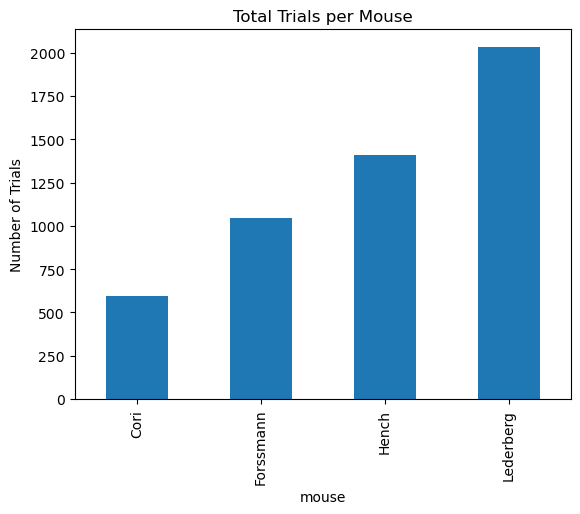

In [4]:
total_trials = summary_df.groupby('mouse')['num_trials'].sum()
total_trials.sort_values().plot(kind='bar')
plt.title('Total Trials per Mouse')
plt.ylabel('Number of Trials')
plt.show()

It is important to note that not all mice underwent equal trials. Some had a higher proportion of left contrast to right contrast, some had a higher proportion of right contrast to left contrast, whilst others had a higher proportion of equal contrast. As can be seen in the graph above, the number of trials overall was unevenly spread. Lederberg, which had the highest success rate overall, underwent almost four times as many tests as Cori did. There can be an argument made that more trials lead to better results, but it is also a fact that Lederberg's starting accuracy over 340 trials (73.8%) was greater than Cori's final accuracy over 593 trials (66.2%), so it is hard to say that simply adding more trials is all that matters. Some mice are simply better at contrast testing than other for some reason, and it is logical to suspect that different mice have more developed brain areas than others.

In [5]:
# Get all unique brain areas
all_brain_areas = sorted(set(str(area) for sess in sessions for area in sess.rx2('brain_area')))

def extract_features(sess):
    num_trials = len(sess.rx2('feedback_type'))
    brain_area_idx = {area: [i for i, a in enumerate(sess.rx2('brain_area')) if str(a) == area] 
                      for area in all_brain_areas}
    features = []
    mouse_name = str(sess.rx2('mouse_name')[0])  # Extract mouse name per session
    for i in range(num_trials):
        feedback_raw = sess.rx2('feedback_type')[i]
        feedback = int((feedback_raw.item() + 1) // 2)
        feat = {
            'contrast_left': sess.rx2('contrast_left')[i].item(),
            'contrast_right': sess.rx2('contrast_right')[i].item(),
            'feedback': feedback,
            'mouse_name': mouse_name  # Add mouse name to each trial
        }
        spks = np.array(sess.rx2('spks')[i])
        for area in all_brain_areas:
            indices = brain_area_idx.get(area, [])
            if indices:
                feat[area] = np.mean(spks[indices, :])
            else:
                feat[area] = np.nan
        features.append(feat)
    return pd.DataFrame(features)

# Process training data
training_data = pd.concat([extract_features(sess) for sess in sessions], ignore_index=True)
X = training_data.drop(['feedback', 'mouse_name'], axis=1)  # Adjusted column name
y = training_data['feedback']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [6]:
def summarize_data(name, data):
    print(f"\n{'='*50}")
    print(f"Summary of {name}:")
    print(f"{'-'*50}")
    
    # Number of Trials
    print(f"Number of Trials: {len(data):>5}")
    
    # Feedback Distribution
    feedback_counts = data['feedback'].value_counts()
    success = feedback_counts.get(1, 0)
    failure = feedback_counts.get(0, 0)
    total = len(data)
    print(f"\nFeedback Distribution:")
    print(f"  Success (1): {success:>4} ({success/total:>6.2%})")
    print(f"  Failure (0): {failure:>4} ({failure/total:>6.2%})")
    
    # Contrast Left Distribution
    print(f"\nContrast Left Distribution:")
    left_counts = data['contrast_left'].value_counts().sort_index()
    for value in [0.0, 0.25, 0.5, 1.0]:
        count = left_counts.get(value, 0)
        print(f"  {value:<4}: {count:>4} ({count/total:>6.2%})")
    
    # Contrast Right Distribution
    print(f"\nContrast Right Distribution:")
    right_counts = data['contrast_right'].value_counts().sort_index()
    for value in [0.0, 0.25, 0.5, 1.0]:
        count = right_counts.get(value, 0)
        print(f"  {value:<4}: {count:>4} ({count/total:>6.2%})")
    
    # Mean Spike Rates (on one line)
    active_areas = 0
    spike_rates = []
    for area in all_brain_areas:
        mean_spike = data[area].mean()
        if not pd.isna(mean_spike):
            active_areas += 1
            spike_rates.append(f"{area}: {mean_spike:.4f}")
    print(f"\nMean Spike Rates per Brain Area (Active): {', '.join(spike_rates)}")
    print(f"\nNumber of Active Brain Areas: {active_areas} out of {len(all_brain_areas)}")
    print(f"{'='*50}")

# Summarize training data per mouse
unique_mice = training_data['mouse_name'].unique()
for mouse in unique_mice:
    mouse_data = training_data[training_data['mouse_name'] == mouse]
    summarize_data(f"Training Data (Mouse: {mouse})", mouse_data)

# Summarize total training data
summarize_data("Training Data (18 Sessions)", training_data)


Summary of Training Data (Mouse: Cori):
--------------------------------------------------
Number of Trials:   593

Feedback Distribution:
  Success (1):  379 (63.91%)
  Failure (0):  214 (36.09%)

Contrast Left Distribution:
  0.0 :  321 (54.13%)
  0.25:   83 (14.00%)
  0.5 :   85 (14.33%)
  1.0 :  104 (17.54%)

Contrast Right Distribution:
  0.0 :  267 (45.03%)
  0.25:   81 (13.66%)
  0.5 :   88 (14.84%)
  1.0 :  157 (26.48%)

Mean Spike Rates per Brain Area (Active): ACA: 0.0248, CA1: 0.0387, CA3: 0.0511, DG: 0.0735, LP: 0.0899, LS: 0.0371, MG: 0.0683, MOs: 0.0221, MRN: 0.1439, NB: 0.0519, POST: 0.0278, SPF: 0.1122, SUB: 0.0601, VISam: 0.0494, VISl: 0.0318, VISp: 0.0304, VISpm: 0.0358, root: 0.0266

Number of Active Brain Areas: 18 out of 62

Summary of Training Data (Mouse: Forssmann):
--------------------------------------------------
Number of Trials:  1045

Feedback Distribution:
  Success (1):  718 (68.71%)
  Failure (0):  327 (31.29%)

Contrast Left Distribution:
  0.0 :  466

Interestingly, each mouse used a different amount of neurons from different areas of the brain for these trials. Mouse Cori uses the least number of neurons, at 18 out of 62, which can explain why Cori had the lowest accuracy amongst all the mice. In contrast, mouse Lederberg uses 32 neurons out of 62, explaining why Lederberg had the highest accuracy out of all the mice at 71%. Since all mice together make up the total active brain areas of 62 out of 62, we can conclude that better performing mice both use more neurons in different brain areas than worse performing mice on top of several overlapping neurons. This leads us to the conclusion that different mice might need different predictive models in order to effectively predict feedback types since the mice undergo the testing differently.

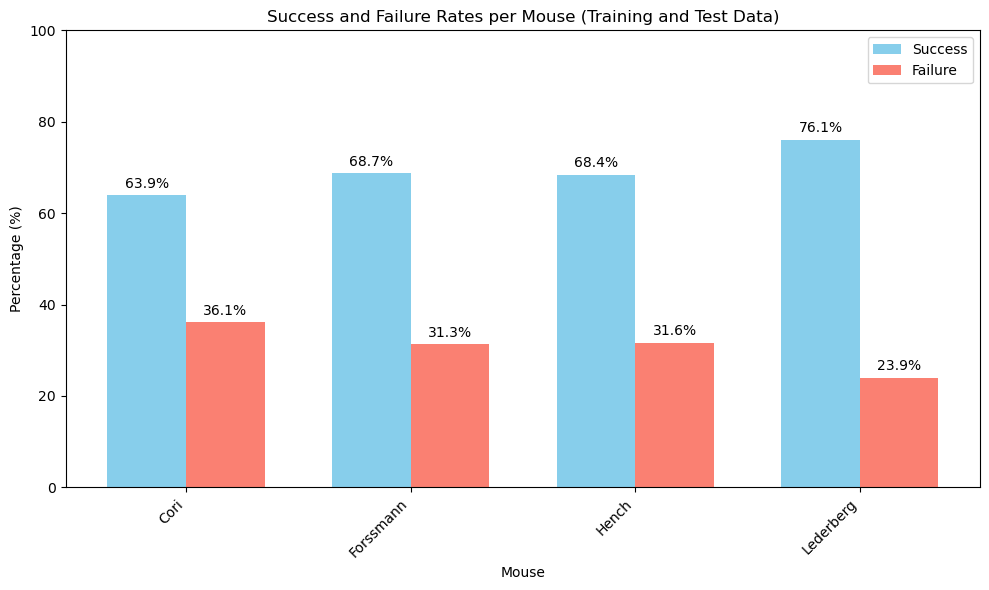

In [7]:
mice = ['Cori', 'Forssmann', 'Hench', 'Lederberg']
success_rates = [63.91, 68.71, 68.39, 76.08]
failure_rates = [36.09, 31.29, 31.61, 23.92]

data = pd.DataFrame({
    'Mouse': mice,
    'Success (%)': success_rates,
    'Failure (%)': failure_rates
})

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(mice))
bars1 = ax.bar([i - bar_width/2 for i in index], data['Success (%)'], bar_width, label='Success', color='skyblue')
bars2 = ax.bar([i + bar_width/2 for i in index], data['Failure (%)'], bar_width, label='Failure', color='salmon')
ax.set_xlabel('Mouse')
ax.set_ylabel('Percentage (%)')
ax.set_title('Success and Failure Rates per Mouse (Training and Test Data)')
ax.set_xticks(index)
ax.set_xticklabels(mice, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 100)

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

To add on the to previous analysis, since Lederberg has the highest overall accuracy and most neurons activated, we can expect the predictive model for Lederberg to be different from the predictive model for Cori, who has the lowest accuracy and least neurons activated. However, since Forssmann and Hench have very similar levels of overall accuracy and neuron brain area spikes, we can expect these two to have similar predictions.

### Section III - Data Integration

Since we have come to the idea that the dataset is affected by the mice being inherently different in terms of brain power and neuron activation, we should take this into consideration when integrating data for modelling purposes.

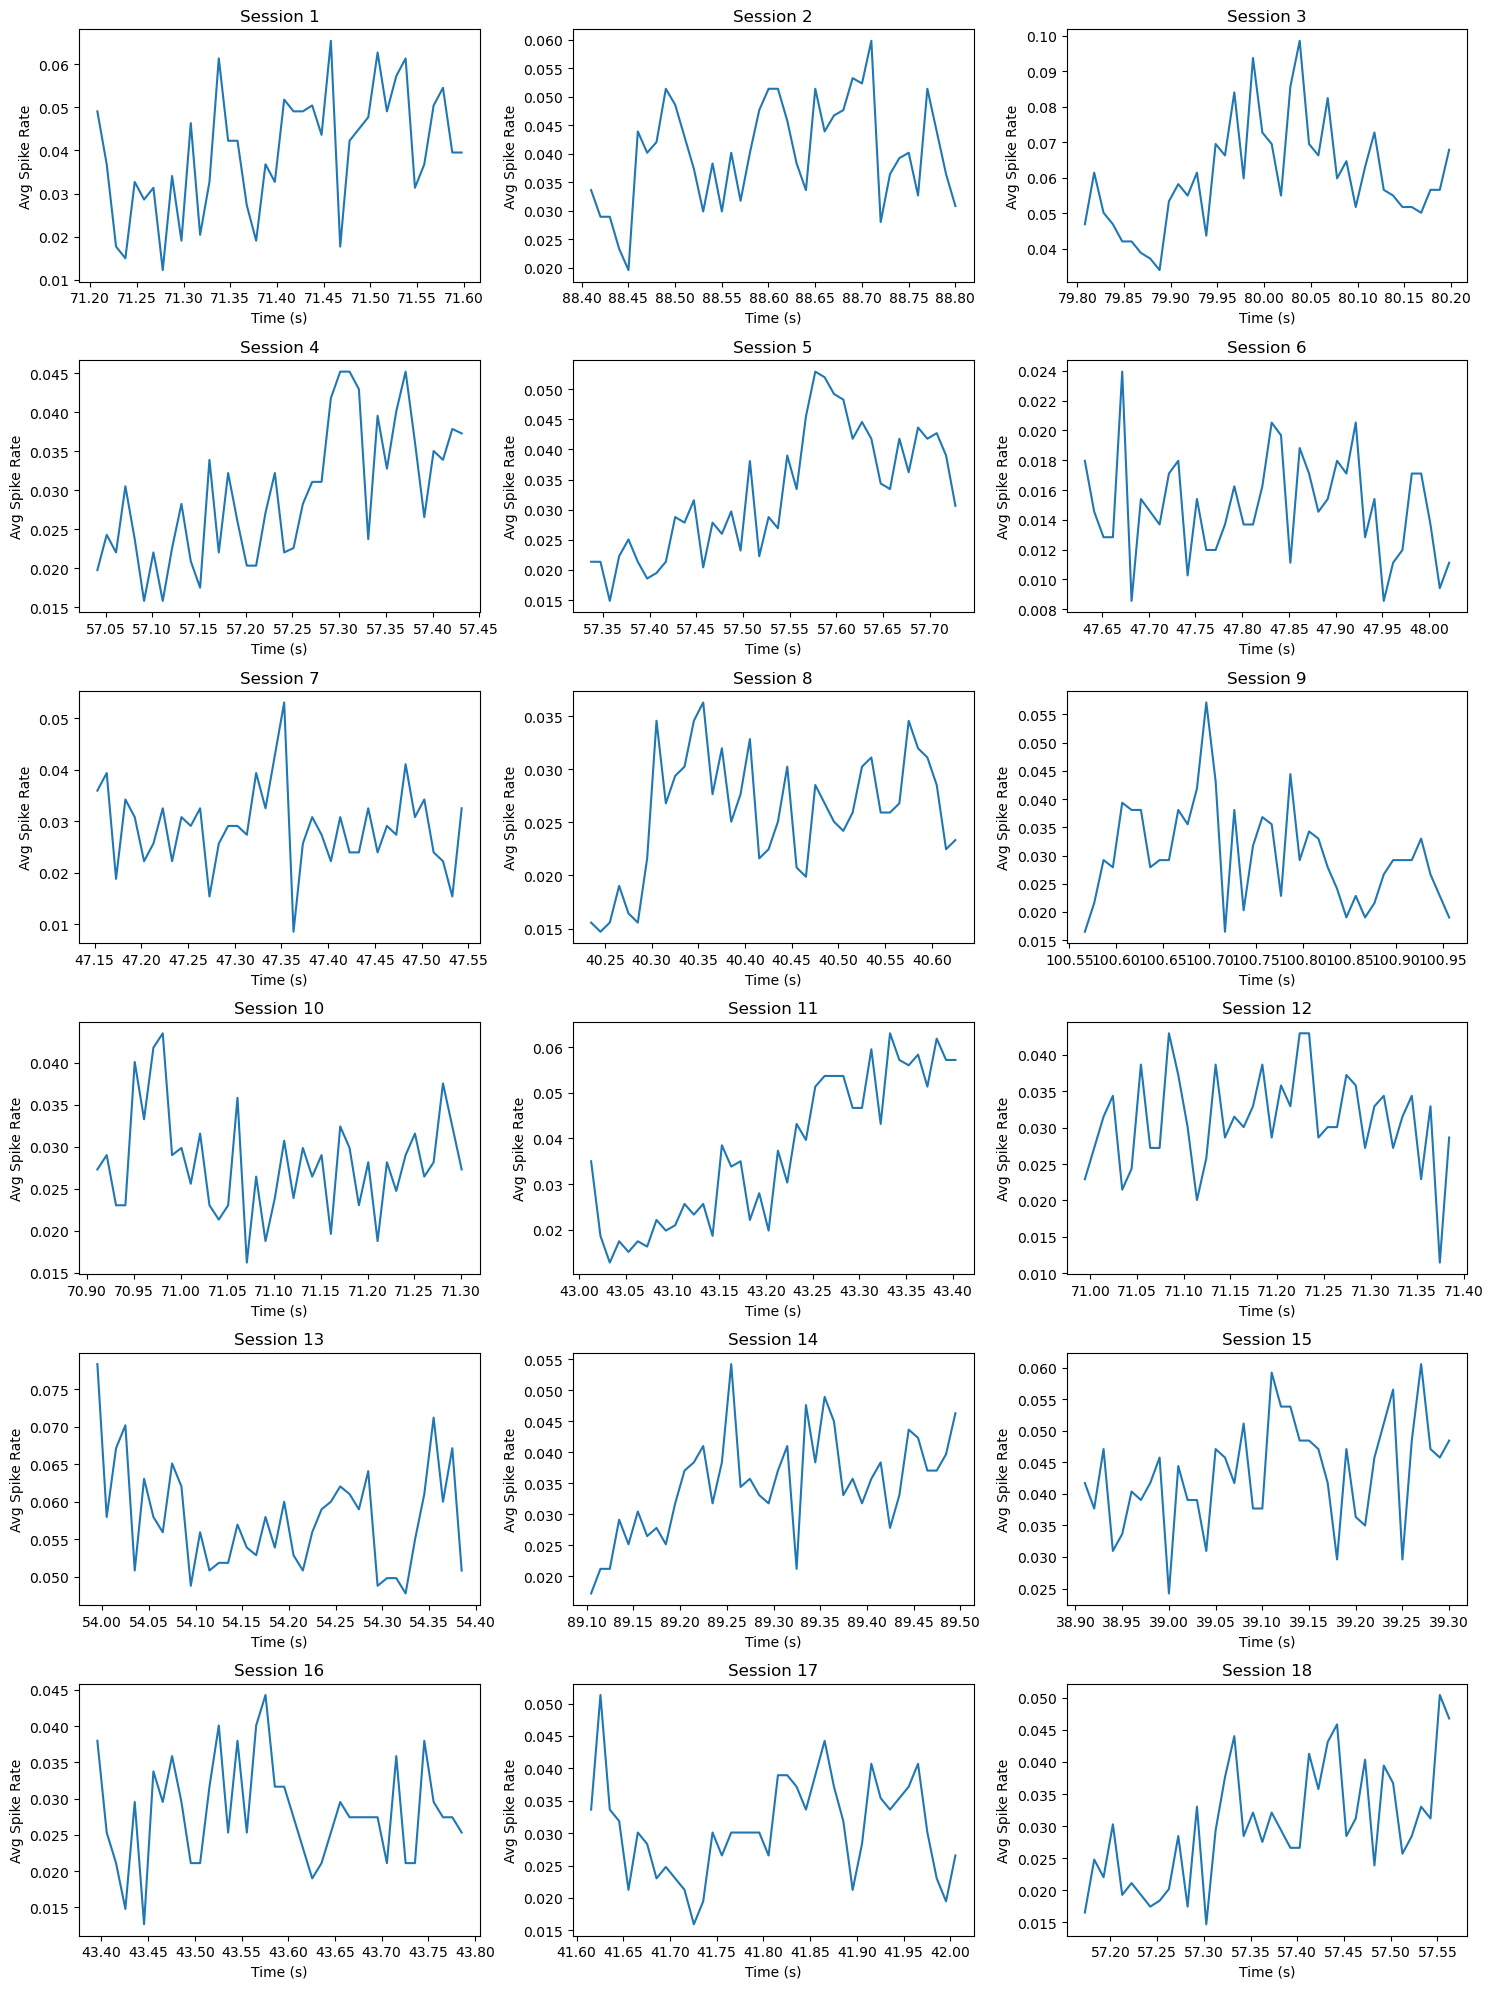

In [8]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))
axes = axes.flatten()

for i in range(18):
    spks_trial = np.array(sessions[i].rx2('spks')[0])
    time_bins = np.array(sessions[i].rx2('time')[0])
    avg_spks = np.mean(spks_trial, axis=0)

    # Plot each session
    axes[i].plot(time_bins, avg_spks)
    axes[i].set_title(f'Session {i + 1}')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Avg Spike Rate')

plt.tight_layout()
plt.show()

Here we can see the spikes in neural activity over time in all 18 sessions. It needs to be further stressed that each mouse is different, since each mouse took different amounts of time in seconds to make their decisions and spike rates to occur. In general Cori took about 70-90 seconds to do this, much higher than other mice on average, which is to be expected since mouse Cori performed the worst out of all the mice. Surprisingly, Lederberg did not take the least amount of time on average but it is actually Forssmann who did at a little more than 50 seconds, since Lederberg took more time on trials 12 and 14. Trial 12 is to be expected since it was the first Lederberg was exposed to testing, but trial 14 is an outlier in this regard. Additionally, trial 14 had Lederberg's lowest success rate (from an earlier table), signifying that something wrong happened during trial 14. This culminates in the idea that there is a large amount of noise in this dataset, since the sessions are so inconsistent even among the same mice.

Explained Variance Ratio: [0.51885674 0.46885588]
Total Variance Explained: 98.77%


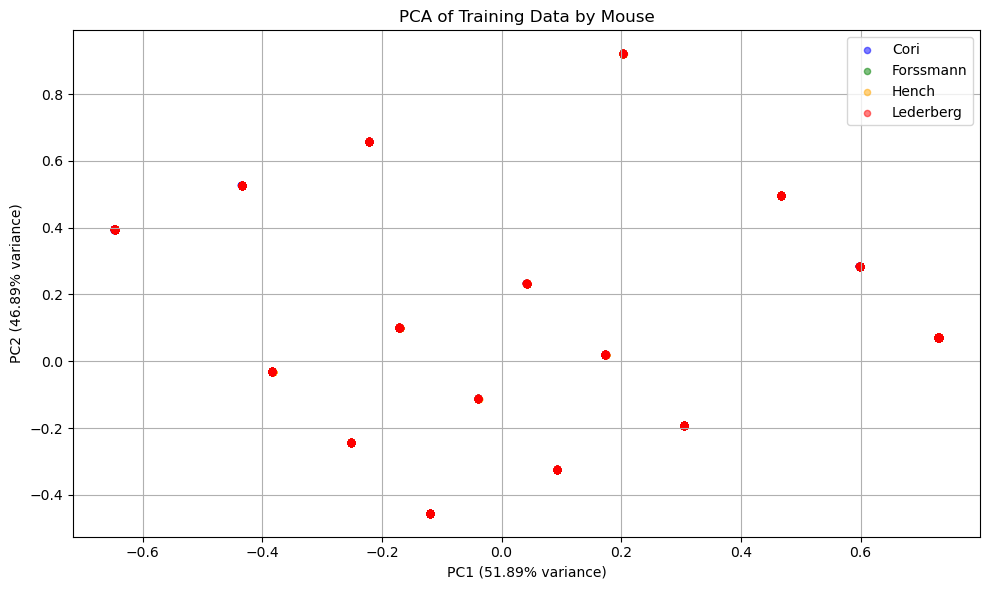

In [9]:
# Apply PCA to training data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_imputed)

print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Variance Explained: {sum(pca.explained_variance_ratio_):.2%}")

# Plot
plt.figure(figsize=(10, 6))
colors = {'Cori': 'blue', 'Forssmann': 'green', 'Hench': 'orange', 'Lederberg': 'red'}
for mouse in training_data['mouse_name'].unique():
    mask = training_data['mouse_name'] == mouse
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors[mouse], label=f"{mouse}", alpha=0.5, s=20)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA of Training Data by Mouse')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

When integrating PCA analysis to the data, the total variance explained is exceptionally high 98.77% with only two principal components (PC1: 51.89%, PC2: 46.89%), meaning that this 2D representation captures nearly the entire structure of the original 64-dimensional feature space (2 contrasts + 62 brain areas). The training data must exhibit strong linear correlations amongst, likely from the correlation between neural activity and accuracy rating, amongst other factors. Since the points are all overlapped on top of each other, the samples are virtually indistinguishable in terms of the PCs used. Though this might seem to suggest that the mice aren't that much different after all, it only serves to indicate that greater neural engagement highly affects the success in decision making and lower neural engagement does the opposite, confirming our postulation that inherent mouse brain capabilities affect success. Furthermore, PCA does not take into account factors like task adaptation and intentions (i.e why Lederberg took so long in trial 14).

### Section IV - Predictive Modeling

Since we have concluded that the mice are very varied in their success and neural activity, it is only right that we use multiple models for this dataset.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Define and train multiple models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Support Vector Classifier': SVC(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{name} Accuracy: {accuracy:.3f}")

Logistic Regression Accuracy: 0.727
Random Forest Accuracy: 0.745
Support Vector Classifier Accuracy: 0.727
Gradient Boosting Accuracy: 0.738
K-Nearest Neighbors Accuracy: 0.706
Linear Discriminant Analysis Accuracy: 0.728


The predictive models used are logistic regression, random forest, support vector classifier, gradient boosting, K-nearest neighbors, and linear discriminant analysis. This is to have as much of a spread as possible so as to achieve the best possible results for each test dataset. As said previously, the mice are so different that it would not make sense to use a single model to predict several mice at a time.

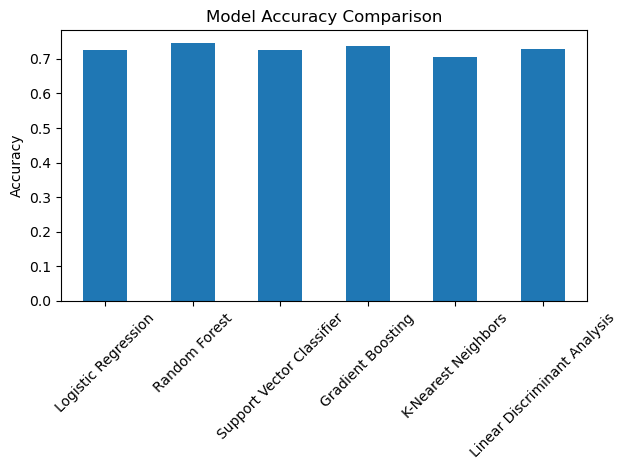

In [11]:
accuracies = {name: model.fit(X_train, y_train).score(X_val, y_val) for name, model in models.items()}
pd.Series(accuracies).plot(kind='bar')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In this graph we can see that the accuracies are all very similar when using all 18 sessions as a training set, ranging from around 70% to 75%. Random forest has the highest accuracy for this portion because it is very robust and can handle widespread data, which further supports our theory that the data is too diverse to be covered by a single model. However, random forest would be the go-to pick if a single predictive model had to be chosen to estimate an unknown number of mice samples due to its consistency and being resilient to noise.

### Section V - Prediction Performance

In this section the models generated from before will be used to predict 2 test datasets: one from Cori (session 1) and one from Lederberg (session 18).

In [12]:
test1 = ro.r['readRDS']('./test/test1.rds')
test2 = ro.r['readRDS']('./test/test2.rds')
test1_data = extract_features(test1)
test2_data = extract_features(test2)

# Summarize test sets
summarize_data("Test Set 1 (Session 1)", test1_data)
summarize_data("Test Set 2 (Session 18)", test2_data)


Summary of Test Set 1 (Session 1):
--------------------------------------------------
Number of Trials:   100

Feedback Distribution:
  Success (1):   72 (72.00%)
  Failure (0):   28 (28.00%)

Contrast Left Distribution:
  0.0 :   46 (46.00%)
  0.25:   19 (19.00%)
  0.5 :   18 (18.00%)
  1.0 :   17 (17.00%)

Contrast Right Distribution:
  0.0 :   43 (43.00%)
  0.25:   11 (11.00%)
  0.5 :   18 (18.00%)
  1.0 :   28 (28.00%)

Mean Spike Rates per Brain Area (Active): ACA: 0.0253, CA3: 0.0504, DG: 0.0546, LS: 0.0368, MOs: 0.0220, SUB: 0.0584, VISp: 0.0422, root: 0.0241

Number of Active Brain Areas: 8 out of 62

Summary of Test Set 2 (Session 18):
--------------------------------------------------
Number of Trials:   100

Feedback Distribution:
  Success (1):   73 (73.00%)
  Failure (0):   27 (27.00%)

Contrast Left Distribution:
  0.0 :   44 (44.00%)
  0.25:   17 (17.00%)
  0.5 :   16 (16.00%)
  1.0 :   23 (23.00%)

Contrast Right Distribution:
  0.0 :   53 (53.00%)
  0.25:   16 (16.00%

Cori in test set 1 has an unusually high success rate in comparison to the training data, while Lederberg in test set 2 has an expected success rate in comparison to the training data. Furthermore, the number of activate brain areas are closer than in the training data as well, even though the activation areas themselves are largely different.

In [13]:
X_test1 = test1_data.drop(['feedback', 'mouse_name'], axis=1)
y_test1 = test1_data['feedback']
X_test2 = test2_data.drop(['feedback', 'mouse_name'], axis=1)
y_test2 = test2_data['feedback']

# Ensure column names match training data and impute
X_test1.columns = X_test1.columns.astype(str)
X_test2.columns = X_test2.columns.astype(str)
X_test1_imputed = imputer.transform(X_test1)
X_test2_imputed = imputer.transform(X_test2)

# Predict and evaluate on test sets
print("\nTest Set 1 (Session 1) Accuracies:")
for name, model in models.items():
    y_pred_test1 = model.predict(X_test1_imputed)
    accuracy = accuracy_score(y_test1, y_pred_test1)
    print(f"{name} Accuracy: {accuracy:.3f}")

print("\nTest Set 2 (Session 18) Accuracies:")
for name, model in models.items():
    y_pred_test2 = model.predict(X_test2_imputed)
    accuracy = accuracy_score(y_test2, y_pred_test2)
    print(f"{name} Accuracy: {accuracy:.3f}")


Test Set 1 (Session 1) Accuracies:
Logistic Regression Accuracy: 0.720
Random Forest Accuracy: 0.770
Support Vector Classifier Accuracy: 0.720
Gradient Boosting Accuracy: 0.800
K-Nearest Neighbors Accuracy: 0.680
Linear Discriminant Analysis Accuracy: 0.650

Test Set 2 (Session 18) Accuracies:
Logistic Regression Accuracy: 0.730
Random Forest Accuracy: 0.720
Support Vector Classifier Accuracy: 0.730
Gradient Boosting Accuracy: 0.740
K-Nearest Neighbors Accuracy: 0.710
Linear Discriminant Analysis Accuracy: 0.760


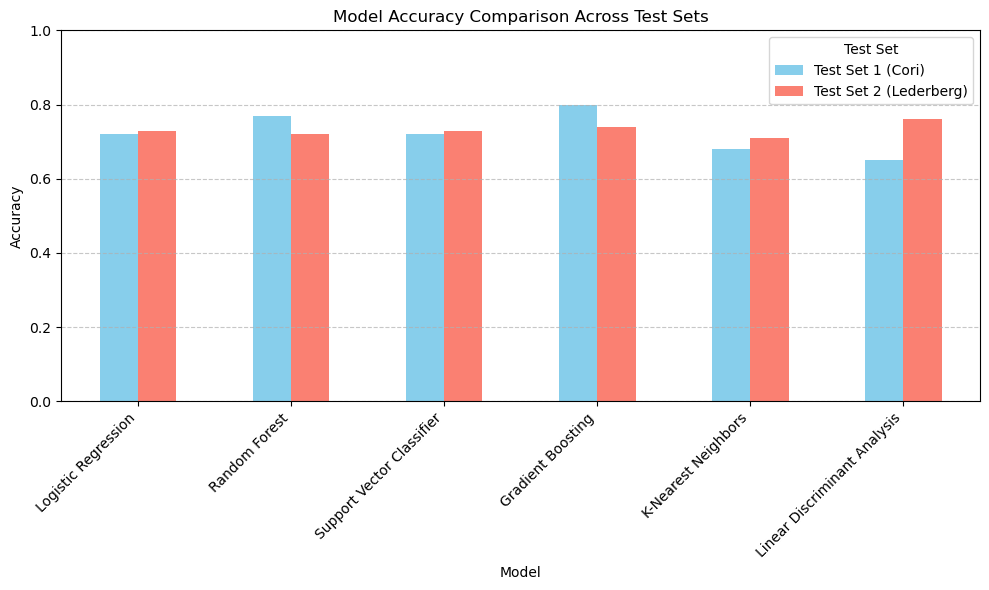

In [14]:
test1_accuracies = {name: accuracy_score(y_test1, model.predict(X_test1_imputed)) 
                    for name, model in models.items()}
test2_accuracies = {name: accuracy_score(y_test2, model.predict(X_test2_imputed)) 
                    for name, model in models.items()}

accuracies_df = pd.DataFrame({
    'Test Set 1 (Cori)': test1_accuracies,
    'Test Set 2 (Lederberg)': test2_accuracies
})

accuracies_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])
plt.title('Model Accuracy Comparison Across Test Sets')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)  # Set y-axis from 0 to 1 for clarity
plt.legend(title='Test Set')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Section VI - Discussion

The strongest prediction model for test set 1 is gradient boosting at 80% accuracy (this is a very good accuracy for this dataset) and the weakest is linear discrimination analysis at 65% accuracy, suggesting that test set 1 has complex, non-linear patterns that are hard to capture with linear, straightforward computation. On the other hand, test set 2 has linear discriminant analysis accuracy at 76% accuracy as its strongest predictor, and K-nearest neighbors as its weakest predictor at 71% accuracy, indicating that its relationships are much more linear than test set 1. However, since test set 1 still had a lower accuracy for K-nearest neighbors, we can conclude that test set 1 had a more different distribution from the training data than test set 2 did. Since the test data is similar to the training data, there is very little overall overfitting of the data. For the most part, the hypothesis that different mice were dissimilar enough in neural activity and trial accuracy to justify multiple different predictive models was mainly correct. To this extent, mouse Lederberg should be using a more linear model such as linear discriminant analysis and mouse Cori should be using a more complex model such as gradient boosting.

In [15]:
import sys
import platform
print("Python version:", sys.version)
print("Platform:", platform.platform())

Python version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]
Platform: macOS-15.0.1-arm64-arm-64bit
